In [ ]:
#Runtime -> Change runtime type-> GPU

> Imagine you're given a book of 5k pages and you need to extract address from every page in the book. Seems tiresome, right? Just in the same manner, now imagine you're given a pile of invoices and you might need to extract the address of the business, the billing amount, the name of the customer, the name of the seller, etc. Now it becomes more complex. 

> Now, again imagine that you had a deep learning model that would do all these tasks for you, all you had to do was to feed it with invoices, watch it do all the stuffs sipping your coffee!

> Hmm.. now it seems cool, isn't it? Let's see this in action and find out how really cool it is.

## Information extraction

> Information extraction is the task of automatically extracting structured information from unstructured and/or semi-structured machine-readable documents and other electronically represented sources. In most of the cases this activity concerns processing human language texts by means of natural language processing.




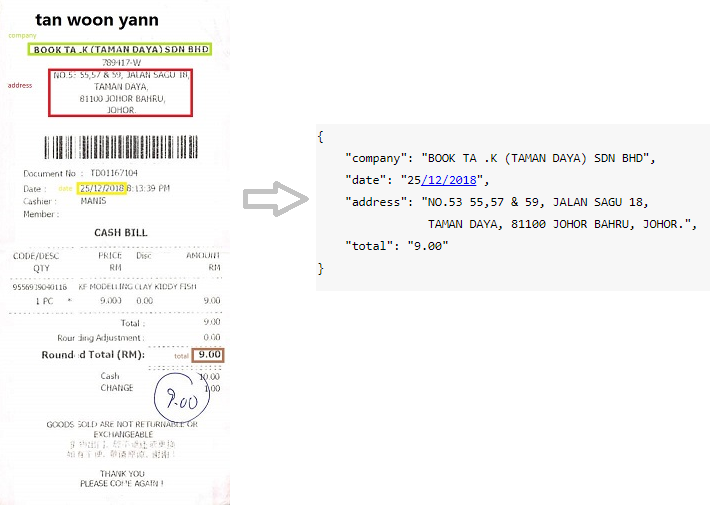

> In this blog we will look how to process SROIE dataset and train PICK-pytorch to get key information from invoice.

> Here is colab notebook [click here](https://colab.research.google.com/drive/17JGtGkJjRRZJYSFNEX2L7tAWbPuSr-_i?usp=sharing) to direct run tutorial code 

## SROIE dataset


> For invoice datset we are using ICDAR 2019 Robust Reading Challenge on Scanned Receipts OCR and Information Extraction Compition Dataset.

>Reference : 
* https://rrc.cvc.uab.es/?ch=13&com=introduction
* https://github.com/zzzDavid/ICDAR-2019-SROIE

**Folder structure**

```
data/
  img/
      000.jpg
      001.jpg    
  box/
      000.csv
      001.csv  
  key/
      000.json
      001.json    
```



<b>Image Example</b>

![Image example](https://github.com/zzzDavid/ICDAR-2019-SROIE/raw/master/data/img/000.jpg)

**Csv data example**
```
x1_1,y1_1,x2_1,y2_1,x3_1,y3_1,x4_1,y4_1,transcript_1

72,25,326,25,326,64,72,64,TAN WOON YANN
50,82,440,82,440,121,50,121,BOOK TA .K(TAMAN DAYA) SDN BND
205,121,285,121,285,139,205,139,789417-W
110,144,383,144,383,163,110,163,NO.53 55,57 & 59, JALAN SAGU 18,
192,169,299,169,299,187,192,187,TAMAN DAYA,
162,193,334,193,334,211,162,211,81100 JOHOR BAHRU,
....
```

**Key data example**



```
{
    "company": "BOOK TA .K (TAMAN DAYA) SDN BHD",
    "date": "25/12/2018",
    "address": "NO.53 55,57 & 59, JALAN SAGU 18, 
                TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.",
    "total": "9.00"
}
```



**Downloading dataset**

In [ ]:
#dataset
!git clone https://github.com/zzzDavid/ICDAR-2019-SROIE.git

Cloning into 'ICDAR-2019-SROIE'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 2386 (delta 50), reused 65 (delta 22), pack-reused 2292
Receiving objects: 100% (2386/2386), 278.63 MiB | 23.17 MiB/s, done.
Resolving deltas: 100% (213/213), done.
Checking out files: 100% (1980/1980), done.


## Preprocess Dataset

We will preprocess Dataset as per PICK-pytorch.<br>
Reference: https://github.com/wenwenyu/PICK-pytorch/blob/master/data/README.md

In [ ]:
## Creating folders for preprocessed dataset
!mkdir boxes_and_transcripts images entities

In [ ]:
## Script for preprocessing dataset
import os
import pandas
import json
import csv
import shutil

## Input dataset
data_path = "ICDAR-2019-SROIE/data/"
box_path = data_path + "box/"
img_path = data_path + "img/"
key_path = data_path + "key/"

## Output dataset
out_boxes_and_transcripts = "/content/boxes_and_transcripts/"
out_images = "/content/images/"
out_entities  = "/content/entities/"

train_samples_list =  []
for file in os.listdir(data_path + "box/"):
  
  ## Reading csv
  with open(box_path +file, "r") as fp:
    reader = csv.reader(fp, delimiter=",")
    ## arranging dataframe index ,coordinates x1_1,y1_1,x2_1,y2_1,x3_1,y3_1,x4_1,y4_1, transcript
    rows = [[1] + x[:8] + [','.join(x[8:]).strip(',')] for x in reader] 
    df = pandas.DataFrame(rows)
  
  ## including ner label dataframe index ,coordinates x1_1,y1_1,x2_1,y2_1,x3_1,y3_1,x4_1,y4_1, transcript , ner tag
  df[10] = 'other'  
  
  ##saving file into new dataset folder
  jpg = file.replace(".csv",".jpg")
  entities = json.load(open(key_path+file.replace(".csv",".json")))
  for key,value in sorted(entities.items()):
    idx = df[df[9].str.contains('|'.join(map(str.strip, value.split(','))))].index
    df.loc[idx, 10] = key

  shutil.copy(img_path +jpg, out_images)
  with open(out_entities + file.replace(".csv",".txt"),"w") as j:  
    print(json.dumps(entities), file=j)
  
  df.to_csv(out_boxes_and_transcripts+file.replace(".csv",".tsv"),index=False,header=False, quotechar='',escapechar='\\',quoting=csv.QUOTE_NONE, )
  train_samples_list.append(['receipt',file.replace('.csv','')])
train_samples_list = pandas.DataFrame(train_samples_list)
train_samples_list.to_csv("train_samples_list.csv")

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


**Folder structure after preprocessing**

```
boxes_and_transcripts/
    000.tsv
    001.tsv
images/
    000.jpg
    001.jpg    
entities/
    000.txt
    001.txt    
```



**Preprocessed data example**<br>
Here we only added ner tag into tsv file

```
index ,x1_1,y1_1,x2_1,y2_1,x3_1,y3_1,x4_1,y4_1, transcript , ner tag
1,72,25,326,25,326,64,72,64,TAN WOON YANN,other
1,50,82,440,82,440,121,50,121,BOOK TA .K(TAMAN DAYA) SDN BND,address
1,205,121,285,121,285,139,205,139,789417-W,other
1,110,144,383,144,383,163,110,163,NO.53 55\,57 & 59\, JALAN SAGU 18,address
1,192,169,299,169,299,187,192,187,TAMAN DAYA,address
1,162,193,334,193,334,211,162,211,81100 JOHOR BAHRU,address
1,217,216,275,216,275,233,217,233,JOHOR.,address
1,50,342,279,342,279,359,50,359,DOCUMENT NO : TD01167104,other
1,50,372,96,372,96,390,50,390,DATE:,other
1,165,372,342,372,342,389,165,389,25/12/2018 8:13:39 PM,date
```



In [ ]:
## document_type, file_name
train_samples_list.head()

,0,1
0,receipt,445
1,receipt,225
2,receipt,523
3,receipt,555
4,receipt,011


**Spliting dataset into train-test sets**

In [ ]:
from sklearn.model_selection import train_test_split
train_test = pandas.read_csv("train_samples_list.csv",dtype=str)
train, test= train_test_split(train_test,test_size=0.2,random_state = 42)

## Model

> For deep learning model we will use PICK-pytorch model.

>PICK is a framework that is effective and robust in handling complex documents layout for Key Information Extraction (KIE) by combining graph learning with graph convolution operation, yielding a richer semantic representation containing the textual and visual features and global layout without ambiguity. 

![Image example](https://github.com/wenwenyu/PICK-pytorch/raw/master/assets/overall.png)

> reference : https://github.com/wenwenyu/PICK-pytorch


```
@inproceedings{Yu2020PICKPK,
  title={{PICK}: Processing Key Information Extraction from Documents using 
  Improved Graph Learning-Convolutional Networks},
  author={Wenwen Yu and Ning Lu and Xianbiao Qi and Ping Gong and Rong Xiao},
  booktitle={2020 25th International Conference on Pattern Recognition (ICPR)},
  year={2020}
}
```



In [ ]:
!git clone https://github.com/wenwenyu/PICK-pytorch.git

Cloning into 'PICK-pytorch'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 218 (delta 1), reused 0 (delta 0), pack-reused 214
Receiving objects: 100% (218/218), 9.97 MiB | 8.62 MiB/s, done.
Resolving deltas: 100% (86/86), done.


**Copy train data into PICK-pytorch data folder**

In [ ]:
for index, row in train.iterrows():
  shutil.copy(out_boxes_and_transcripts+str(row[2])+".tsv",'/content/PICK-pytorch/data/data_examples_root/boxes_and_transcripts/')
  shutil.copy(out_images+str(row[2])+".jpg",'/content/PICK-pytorch/data/data_examples_root/images/')
  shutil.copy(out_entities +str(row[2])+".txt", '/content/PICK-pytorch/data/data_examples_root/entities/')

train.drop(['Unnamed: 0'], axis = 1,inplace = True)
train.reset_index(inplace= True)
train.drop(['index'], axis = 1,inplace = True)
train.to_csv("/content/PICK-pytorch/data/data_examples_root/train_samples_list.csv",header = False)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


**Copy test data into PICK-pytorch data folder**

In [ ]:
!mkdir '/content/PICK-pytorch/data/test_data_example/entities/'

In [ ]:
for index, row in test.iterrows():
  shutil.copy(out_boxes_and_transcripts+str(row[2])+".tsv",'/content/PICK-pytorch/data/test_data_example/boxes_and_transcripts/')
  shutil.copy(out_images+str(row[2])+".jpg",'/content/PICK-pytorch/data/test_data_example/images/')
  shutil.copy(out_entities +str(row[2])+".txt", '/content/PICK-pytorch/data/test_data_example/entities/')

test.drop(['Unnamed: 0'], axis = 1,inplace = True)
test.reset_index(inplace= True)
test.drop(['index'], axis = 1,inplace = True)
test.to_csv("/content/PICK-pytorch/data/test_data_example/test_samples_list.csv",header = False)

In [ ]:
## Removing data once it is copied into PICK-pytorch data folder
!rm /content/boxes_and_transcripts/*.tsv
!rm /content/images/*.jpg
!rm /content/entities/*.txt

In [ ]:
%cd PICK-pytorch/

/content/PICK-pytorch


entities_list.py contains the name of your entity class.<br>
Here we have 4 entities

*   company
*   address
*   date
*   total

In [ ]:
%%writefile utils/entities_list.py
# -*- coding: utf-8 -*-
# @Author: Wenwen Yu
# @Created Time: 7/8/2020 9:34 PM

Entities_list = [
    "company",
    "address",
    "date",
    "total"
]

Overwriting utils/entities_list.py


In [ ]:
## Installing requirements for running PICK-pytorch
!pip install -r requirements.txt
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

     |████████████████████████████████| 6.6MB 5.5MB/s 
     |████████████████████████████████| 43.7MB 71kB/s 
     |████████████████████████████████| 17.3MB 205kB/s 
     |████████████████████████████████| 10.1MB 49.2MB/s 
     |████████████████████████████████| 481kB 52.4MB/s 
     |████████████████████████████████| 71kB 9.7MB/s 
     |████████████████████████████████| 71kB 9.9MB/s 
     |████████████████████████████████| 753.2MB 14kB/s 
     |████████████████████████████████| 266kB 49.4MB/s 
     |████████████████████████████████| 675kB 48.5MB/s 
     |████████████████████████████████| 317kB 54.0MB/s 
     |████████████████████████████████| 102kB 13.7MB/s 
     |████████████████████████████████| 1.1MB 44.7MB/s 
     |████████████████████████████████| 890kB 50.5MB/s 
     |████████████████████████████████| 3.8MB 45.3MB/s 
     |████████████████████████████████| 6.7MB 48.7MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 
  Created wheel for overrides: filename=overrides-3.0.

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4MB 26kB/s 
     |████████████████████████████████| 6.6MB 47.3MB/s 
  Found existing installation: torch 1.5.1
    Uninstalling torch-1.5.1:
      Successfully uninstalled torch-1.5.1
  Found existing installation: torchvision 0.6.1
    Uninstalling torchvision-0.6.1:
      Successfully uninstalled torchvision-0.6.1


## Training
Train atleast 100 epoch for better results.

In [ ]:
#!/bin/bash
!python -m torch.distributed.launch --nnode=1 --node_rank=0 --nproc_per_node=1 \
   train.py -c config.json -d 0 --local_world_size 1
  # --resume /content/PICK-pytorch/saved/models/PICK_Default/test_0917_074722/model_best.pth ##uncomment for resume training

2020-10-03 05:37:10.929766: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
[2020-10-03 05:37:13,574 - train - INFO] - Distributed GPU training model start...
[2020-10-03 05:37:13,574 - train - INFO] - [Process 372] Initializing process group with: {'MASTER_ADDR': '127.0.0.1', 'MASTER_PORT': '29500', 'RANK': '0', 'WORLD_SIZE': '1'}
[2020-10-03 05:37:13,575 - train - INFO] - [Process 372] world_size = 1, rank = 0, backend=nccl
[2020-10-03 05:37:13,592 - train - INFO] - Dataloader instances created. Train datasets: 500 samples Validation datasets: 126 samples.
[2020-10-03 05:37:14,399 - train - INFO] - Model created, trainable parameters: 68567386.
[2020-10-03 05:37:14,400 - train - INFO] - Optimizer and lr_scheduler created.
[2020-10-03 05:37:14,400 - train - INFO] - Max_epochs: 100 Log_per_step: 10 Validation_per_step: 50.
[2020-10-03 05:37:14,400 - train - INFO] - Training start...
[2020-10-03 05:37:14,402 - trainer

## Testing

In [ ]:
##creating testing folders
!mkdir /content/test_img /content/test_boxes_and_transcripts

In [ ]:
## copy one file from test sample
import os
import shutil
data_path = "data/test_data_example/boxes_and_transcripts/"
image_path = "data/test_data_example/images/"

out_img_path = "/content/test_img/"
out_box_path = "/content/test_boxes_and_transcripts/"

for file in os.listdir(data_path)[:10]:
  shutil.copy(data_path+file,out_box_path)
  shutil.copy(image_path+file.replace(".tsv",".jpg"),out_img_path)

In [ ]:
## change model_best.pth path
!python test.py --checkpoint saved/models/PICK_Default/test_1003_053713/model_best.pth \
                --boxes_transcripts {out_box_path} \
                --images_path {out_img_path} --output_folder /content/output/ \
                --gpu 0 --batch_size 2

2020-10-03 10:07:50.457224: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Loading checkpoint: saved/models/PICK_Default/test_1003_053713/model_best.pth 
with saved mEF 0.6338 ...
5it [00:02,  1.83it/s]


You can see predictions in output folder.

It will look something like this

```
company	ADVANCO COMPANY,co
address	NO 1&3\, JALAN ANGSA DELIMA 12
address	WANGSA LINK\, WANGSA MAJU
address	53300 KUALA LUMPUR
date	23/03/2018
```





**If you like this post, HIT clap!Thanks for reading.**